In [ ]:
#Libraries
import mgwr.sel_bw
import mgwr
import pandas as pd
import geopandas as gpd
import numpy as np
import time
import os
import ee
import geetools
import geemap
from osgeo import gdal
from osgeo import osr
import fiona
import matplotlib.pyplot as plt
from matplotlib import pyplot
import folium
from folium import plugins
from IPython.display import Image
from IPython.core.display import display, HTML
import patsy
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.transform import Affine
from rasterio.plot import show
import geocube
from geocube.api.core import make_geocube

In [2]:
#Earth Engine initialize

basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}


def add_ee_layer(self, ee_object, vis_params, name):
    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Google Earth Engine',
                name=name,
                overlay=True,
                control=True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Google Earth Engine',
                name=name,
                overlay=True,
                control=True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
                data=ee_object.getInfo(),
                name=name,
                overlay=True,
                control=True
            ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Google Earth Engine',
                name=name,
                overlay=True,
                control=True
            ).add_to(self)

    except:
        print("Could not display {}".format(name))


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWgwdcpSaWMW5Ke2COrVJ3IEP9CH4KttaVqXMlNANiOBeReJMi1lBNI

Successfully saved authorization token.


In [12]:
#Image collection, cloud masking and mosaic
AOI = geemap.shp_to_ee("D:/GEE_GWR/Data/Treatment_final_2020_UTM.shp")
shp = fiona.open("D:/GEE_GWR/Data/Treatment_final_2020_UTM.shp")
geom = shp.bounds
geom_list = list(geom)
print(geom_list)
area = ee.Geometry.Rectangle(geom_list)

START_DATE = '2021-01-01'
END_DATE = '2021-06-30'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50


def get_s2_sr_cld_col(AOI, START_DATE, END_DATE):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(AOI)
        .filterDate(START_DATE, END_DATE)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI)
        .filterDate(START_DATE, END_DATE))
    clip_cloudless_col = s2_cloudless_col.map(lambda image: image.clip(area))
    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)


def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')
    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)
    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));
    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))
    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')
    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)
    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)
    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))
    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)



s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

img = s2_sr_cld_col_eval_disp.mosaic()

    # Subset layers and prepare them for display.
clouds = img.select('clouds').selfMask()
shadows = img.select('shadows').selfMask()
dark_pixels = img.select('dark_pixels').selfMask()
probability = img.select('probability')
cloudmask = img.select('cloudmask').selfMask()
cloud_transform = img.select('cloud_transform')

s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()
    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)


s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())




NDVI  = ee.Image(s2_sr_median.normalizedDifference(['B8', 'B4'])).rename(["NDVI"])
NDVI_clip = ee.Image(NDVI).clip(area)

[561954.299710469, 6241519.427032356, 562664.7571437607, 6241780.727141878]


In [14]:
#show map, give it a few minutes to laod tiles
vis_params = {
  'min': 0.07,
  'max': 0.45,
  'palette': ['green','yellow','red']}

# Create a folium map object.
my_map = folium.Map(location=[-33.95, 117.68], width=750, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

my_map.add_ee_layer(NDVI.updateMask(NDVI.gt(0)), vis_params, 'NDVI')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)

c:\python39\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


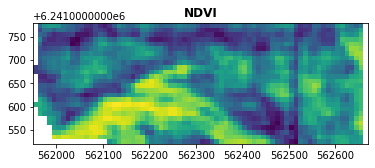

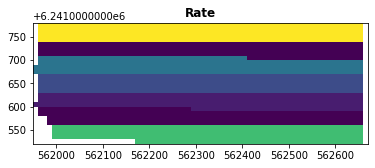

Band1 has shape (26, 72)
(1872, 1)
(1872, 1)
(1872, 1)
(1872, 1)
32767
0.7022059
(1872, 4)
[[-3.40282306e+38  3.27670000e+04  5.61955000e+05  6.24177500e+06]
 [ 4.15730327e-01  3.26000000e+02  5.61965000e+05  6.24177500e+06]
 [ 4.81195092e-01  3.26000000e+02  5.61975000e+05  6.24177500e+06]
 ...
 [ 4.93342429e-01  2.26000000e+02  5.62645000e+05  6.24152500e+06]
 [ 5.00169754e-01  2.26000000e+02  5.62655000e+05  6.24152500e+06]
 [-3.40282306e+38  3.27670000e+04  5.62665000e+05  6.24152500e+06]]
======== Fitted ===================

Summary of Results

Model type                                                         Gaussian
Number of observations:                                                1789
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             17.506
Log-likelihood:                      

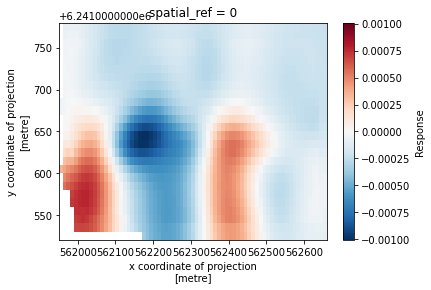

In [17]:
ndvi_path = "C:/Users/285908i/Desktop/GEE_GWR/Data/UTM 2/ndvi.tif"
ndvi = rasterio.open(ndvi_path)
rasterio.plot.show(ndvi, title = "NDVI")

rate_path = "C:/Users/285908i/Desktop/GEE_GWR/Data/UTM 2/rate_clip.tif"
rate = rasterio.open(rate_path)
rasterio.plot.show(rate, title = "Rate")

dst_crs = 'EPSG:32750'

ndvi_arr = ndvi.read(1).reshape(-1,1)
rate_arr = rate.read(1).reshape(-1,1)


with rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/UTM 2/ndvi.tif") as src:
            band1 = src.read(1)
            print('Band1 has shape', band1.shape)
            height = band1.shape[0]
            width = band1.shape[1]
            cols, rows = np.meshgrid(np.arange(width), np.arange(height))
            xs, ys = rasterio.transform.xy(src.transform, rows, cols)
            x= np.array(xs).reshape(-1,1)
            y= np.array(ys).reshape(-1,1)
print(x.shape)
print(y.shape)
print(ndvi_arr.shape)
print(rate_arr.shape)
print(np.max(rate_arr))
print(np.max(ndvi_arr))


stack = np.column_stack([ndvi_arr,rate_arr,x,y])
print(stack.shape)
print(stack)

df = pd.DataFrame({'NDVI': stack[:, 0], 'Rate': stack[:, 1],'X': stack[:, 2], 'Y': stack[:, 3]})
df = df.dropna(axis= 0, how = 'any')

df = df[~(df['Rate'] > 500)]  

coords = np.column_stack([df[['X','Y']]])

# bw = mgwr.sel_bw.Sel_BW(coords,
#                         np.asarray(resp),
#                         np.asarray(predi),
#                         fixed=False,
#                         kernel='gaussian',
#                         spherical=False)
#print('Searching for optimum bandwidth...')
#print(bw.search())


model = mgwr.gwr.GWR(coords,
                     np.asarray(df[['NDVI']]),
                     np.asarray(df[['Rate']]),
                     bw=50,
                     kernel = 'gaussian',
                     fixed = False,
                     constant = True,
                     spherical = False
                     )


results = model.fit()
print('======== Fitted ===================\n')

print("Summary of Results\n")
print( results.summary())

scale = results.scale
residuals = results.resid_response

pred_results = model.predict(coords, df[['Rate']], scale, residuals)
pred_results.predictions


df['Intercept'] = results.params[:, 0]
df['Response'] = results.params[:, 1]

print(df.head)


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(x=df.X, y=df.Y)
)


gdf = gdf.set_crs(epsg = '32750')
print(gdf)

#fig, (axr, axg) = pyplot.subplots(1,2, figsize=(21,7))
cube_int = make_geocube(
     gdf,
     measurements=["Intercept"],
     #output_crs = dst_crs, 
     resolution=(10, -10),
)

#cube_int.Intercept.plot()
#cube_int.Intercept.rio.to_raster("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Intercept.tif")

cube_resp = make_geocube(
     gdf,
     measurements=["Response"],
     #output_crs = dst_crs, 
     resolution=(10, -10),
)

cube_resp.Response.plot()
# print(cube)
#cube_resp.Response.rio.to_raster("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Response.tif")

int_ras = rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Intercept.tif")
#rasterio.plot.show(int_ras, title = "Intercept")

resp_ras = rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Response.tif")
#rasterio.plot.show(resp_ras, title = "Resp")



<AxesSubplot:title={'center':'Response'}>

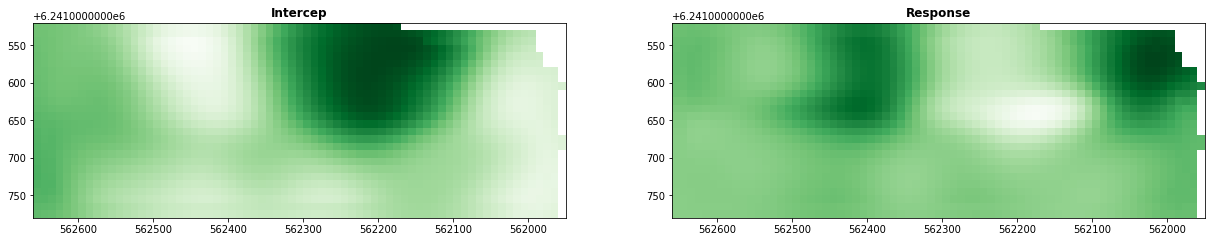

In [18]:
fig, (axr, axg) = pyplot.subplots(1,2, figsize=(21,7))
int_ras = rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Intercept.tif")
#rasterio.plot.show(int_ras, title = "Intercept")

resp_ras = rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/Result/Response.tif")
#rasterio.plot.show(resp_ras, title = "Resp")
show((int_ras, 1), ax=axr, cmap='Greens', title='Intercep')
show((resp_ras, 1), ax=axg, cmap='Greens', title='Response')

In [9]:
with rasterio.open("C:/Users/285908i/Desktop/GEE_GWR/Data/UTM 2/rate_clip.tif") as src:
            band1 = src.read(1)
            print('Band1 has shape', band1.shape)
            height = band1.shape[0]
            width = band1.shape[1]
            profile = src.profile
            transform = src.transform
        


print(profile)
print(transform)
#print(band1)


Band1 has shape (26, 72)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 72, 'height': 26, 'count': 1, 'crs': CRS.from_epsg(32750), 'transform': Affine(10.0, 0.0, 561950.0,
       0.0, -10.0, 6241780.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}
| 10.00, 0.00, 561950.00|
| 0.00,-10.00, 6241780.00|
| 0.00, 0.00, 1.00|
